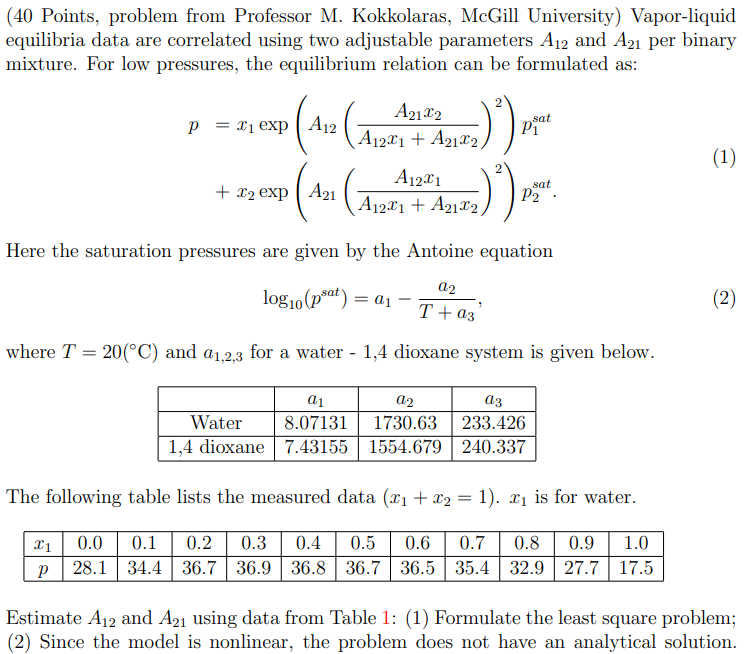

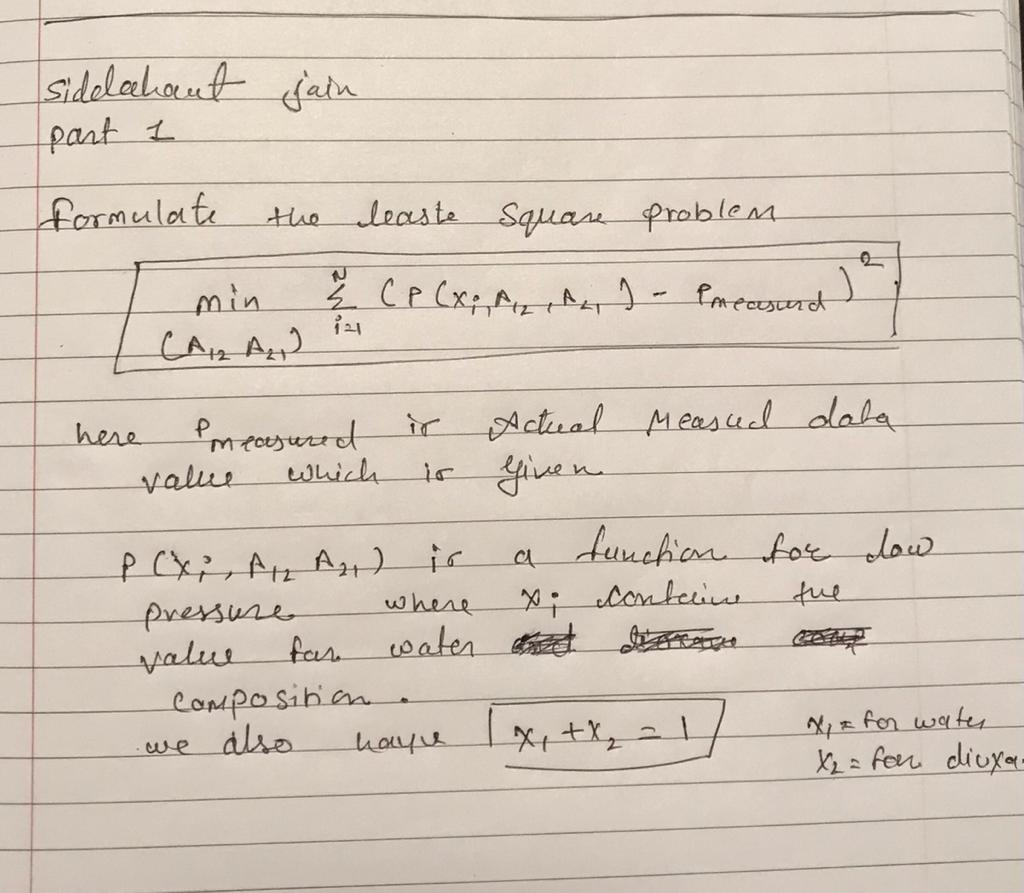

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [ ]:
global x1,x2, T, p1_sat, p2_sat, p_data
x1 = np.arange(0, 1.1, 0.1)
x2 = 1-x1
x1 = torch.tensor(x1, requires_grad=False)
x2 = torch.tensor(x2, requires_grad=False)

T = 20 # Temprature

a = np.array([[8.07131, 1730.63, 233.426],
              [7.43155, 1554.679, 240.337]])
p1_sat = 10 ** (a[0, 0] - (a[0, 1] / (T + a[0, 2])))   #By Antoine equation
p2_sat = 10 ** (a[1, 0] - (a[1, 1] / (T + a[1, 2]))) #By Antoine equation

measured_pressure_data = np.array([[28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5]])
measured_pressure_data = torch.tensor(measured_pressure_data, requires_grad=False)

In [ ]:
A = Variable(torch.tensor([1.0, 1.0]), requires_grad=True) # Initial A12 and A21 values

In [ ]:
# Define functons
pressure = lambda A : x1 * torch.exp(A[0] * (A[1] * x2 / (A[0] * x1 + A[1] * x2)) ** 2) * p1_sat + \
                      x2 * torch.exp(A[1] * (A[0] * x1 / (A[0] * x1 + A[1] * x2)) ** 2) * p2_sat

def obj_fun(pressure, measured_pressure_data):
      # objective function 
    return ((pressure - measured_pressure_data) ** 2).sum()

In [ ]:
def linesearch(A):
    alpha = 1
    t = 0.5
    def pi(A):
      return obj_fun(pressure(A), measured_pressure_data) - alpha * t * torch.matmul(torch.transpose(A.grad, -1, 0),A.grad)
    while pi(A) < obj_fun(pressure(A - alpha* A.grad),measured_pressure_data):
      alpha = 0.5 * alpha
    return alpha

In [ ]:
iter = 0
max_iter=1000
termaniaton = False
while  iter<=max_iter and termaniaton==False:
    P = pressure(A)
    error = obj_fun(P, measured_pressure_data)
    error.backward()
    alpha = linesearch(A)
    grad_norm = torch.norm(A.grad)
    if grad_norm < 1e-06:
      termaniaton=True
    with torch.no_grad():
        A -= alpha * A.grad
        A.grad.zero_()
    iter += 1

A12 and A21 is: tensor([1.9584, 1.6892], requires_grad=True)


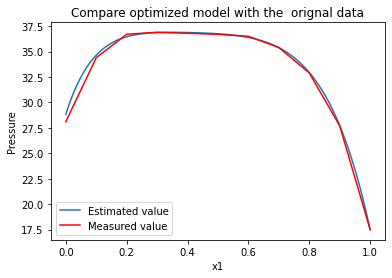

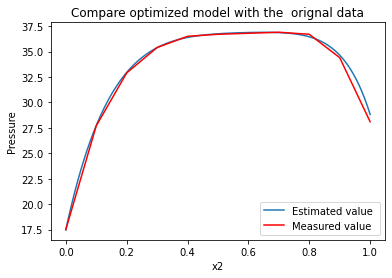

In [ ]:

print('A12 and A21 is:', A)

#Compare optimized model with the  orignal data
x1= np.linspace(0, 1, 1000)
x2 = 1-x1
x1 = torch.tensor(x1, requires_grad=False)
x2 = torch.tensor(x2, requires_grad=False)
y_estimated = pressure(A)
y_estimated= y_estimated.detach().numpy()
x1_data = np.arange(0, 1.1, 0.1)
x2_data = 1- x1_data


fig, ax = plt.subplots()
ax.plot(x1.numpy(), y_estimated)
ax.plot(x1_data, measured_pressure_data.detach().numpy()[0], color='red')
plt.ylabel('Pressure')
plt.xlabel('x1')
plt.legend(['Estimated value','Measured value'])
plt.title("Compare optimized model with the  orignal data")
plt.show()

fig, ax = plt.subplots()
ax.plot(x2.numpy(), y_estimated)
ax.plot(x2_data, measured_pressure_data.detach().numpy()[0], color='red')
plt.ylabel('Pressure')
plt.xlabel('x2')
plt.legend(['Estimated value ','Measured value'])
plt.title("Compare optimized model with the  orignal data")
plt.show()